# **Malaria Diagnosis Prediction Using Logistic Regression and SGD**
This notebook uses the Kenya Malaria Prediction Dataset and applies:

- Data preprocessing  
- Encoding categorical features  
- Feature scaling  
- Logistic Regression using Stochastic Gradient Descent (SGD)  
- Model evaluation & visualization  


In [1]:
# 🔹 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [2]:
import os
import gdown

# Google Drive file ID for your malaria dataset
file_id = "1WyWSRYFgJ0p_OIKe4q5tGhadEhC4NT_D"

# Construct direct download URL
file_url = f"https://drive.google.com/uc?id={file_id}"

# Local CSV filename
csv_filename = "Kenya Malaria_Prediction Dataset by who.csv"

# Download CSV if missing
if not os.path.exists(csv_filename):
    print(f"{csv_filename} not found. Downloading from Google Drive...")
    gdown.download(file_url, csv_filename, quiet=False)

# Load dataset
df = pd.read_csv(csv_filename)
df.head()


,Patient ID,Age,Gender,Region,Fever,Headache,Chills,Sweats,Fatigue,Hemoglobin (g/dL),Platelet (cells/μL),WBC (cells/μL),Parasite Detected,Diagnosis
0,1,52,Male,Rural,Yes,No,Yes,No,Yes,12.2,367281,10578,No,Negative
1,2,93,Male,Rural,Yes,Yes,No,Yes,Yes,11.5,261529,6367,Yes,Negative
2,3,15,Male,Rural,Yes,Yes,Yes,No,No,12.5,383009,11904,No,Negative
3,4,72,Female,Urban,Yes,No,Yes,No,No,12.7,245800,11793,No,Negative
4,5,61,Male,Rural,No,Yes,Yes,No,No,11.6,379350,10677,No,Negative


### Clean data & set up target variable
- Drop Patient ID  
- Convert "Diagnosis" into binary:
  - Positive → 1  
  - Negative → 0  


In [3]:
# Drop non-informative column
df = df.drop("Patient ID", axis=1)

# Encode target variable
df["Diagnosis"] = df["Diagnosis"].map({"Positive": 1, "Negative": 0})

df.head()


,Age,Gender,Region,Fever,Headache,Chills,Sweats,Fatigue,Hemoglobin (g/dL),Platelet (cells/μL),WBC (cells/μL),Parasite Detected,Diagnosis
0,52,Male,Rural,Yes,No,Yes,No,Yes,12.2,367281,10578,No,0
1,93,Male,Rural,Yes,Yes,No,Yes,Yes,11.5,261529,6367,Yes,0
2,15,Male,Rural,Yes,Yes,Yes,No,No,12.5,383009,11904,No,0
3,72,Female,Urban,Yes,No,Yes,No,No,12.7,245800,11793,No,0
4,61,Male,Rural,No,Yes,Yes,No,No,11.6,379350,10677,No,0


### Separate Features and Target

In [4]:
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

#  3. Preprocessing Pipeline
We apply:
- One-hot encoding to categorical variables  
- Scaling to numerical columns  


In [5]:
# Identify categorical and numerical columns
categorical_cols = ["Gender", "Region", "Fever", "Headache", "Chills", 
                    "Sweats", "Fatigue", "Parasite Detected"]

numeric_cols = ["Age", "Hemoglobin (g/dL)", "Platelet (cells/μL)", "WBC (cells/μL)"]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first"), categorical_cols),
        ("numeric", StandardScaler(), numeric_cols)
    ]
)


#  4. Build SGD Logistic Regression Pipeline


In [18]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier

model = Pipeline(steps=[
    ("preprocess", preprocessor),      
    ("smote", SMOTE(random_state=42)), 
    ("sgd", SGDClassifier(
        loss="log_loss",
        learning_rate="optimal",
        max_iter=3000,
        tol=None,                # ensures full training (VERY IMPORTANT)
        alpha=0.0001,
        class_weight="balanced",
        warm_start=True,         # enables accumulation of the loss curve
        early_stopping=False,    # prevents premature stopping
        random_state=42
    ))
])


#  5. Train-Test Split


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#  6. Train the Model


In [20]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Region', 'Fever',
                                                   'Headache', 'Chills',
                                                   'Sweats', 'Fatigue',
                                                   'Parasite Detected']),
                                                 ('numeric', StandardScaler(),
                                                  ['Age', 'Hemoglobin (g/dL)',
                                                   'Platelet (cells/μL)',
                                                   'WBC (cells/μL)'])])),
                ('smote', SMOTE(random_state=42)),
                ('sgd',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=3000, random_state=42, tol=None,
                               warm_start=True))])

In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
y_train_np = y_train.values


In [24]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt

sgd_loss_model = SGDClassifier(
    loss="log_loss",
    learning_rate="optimal",
    max_iter=1,
    warm_start=True,
    tol=None,
    early_stopping=False,
    random_state=42
)


In [25]:
def compute_log_loss(y_true, y_pred_proba):
    eps = 1e-8
    return -np.mean(y_true*np.log(y_pred_proba + eps) + (1 - y_true)*np.log(1 - y_pred_proba + eps))


In [26]:
loss_curve = []
epochs = 300
classes = [0, 1]

for epoch in range(epochs):
    # One epoch of SGD
    sgd_loss_model.partial_fit(X_train_processed, y_train_np.ravel(), classes=classes)

    # Predict probabilities after this epoch
    y_pred_proba = sgd_loss_model.predict_proba(X_train_processed)[:, 1].reshape(-1, 1)

    # Compute manual log loss
    loss = compute_log_loss(y_train_np, y_pred_proba)
    loss_curve.append(loss)


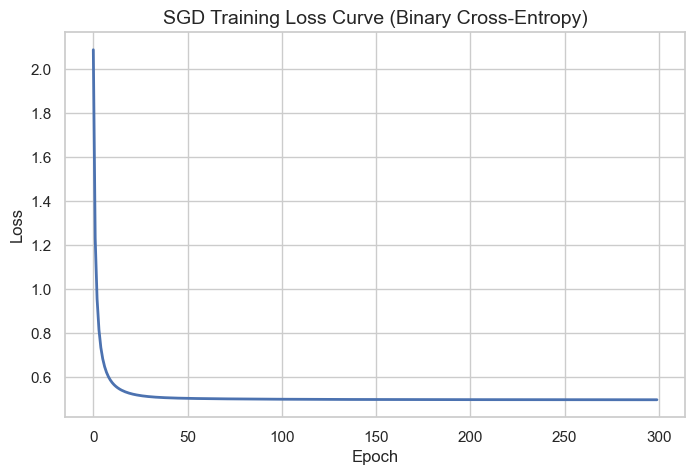

In [27]:
plt.figure(figsize=(8,5))
plt.plot(loss_curve, linewidth=2)
plt.title("SGD Training Loss Curve (Binary Cross-Entropy)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.show()


#  7. Model Evaluation
Accuracy, Precision, Recall, F1 Score


In [9]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(" MODEL PERFORMANCE")
print("-----------------------")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


 MODEL PERFORMANCE
-----------------------
Accuracy : 0.618
Precision: 0.2215568862275449
Recall   : 0.37755102040816324
F1 Score : 0.2792452830188679


# 8. Confusion Matrix Visualization


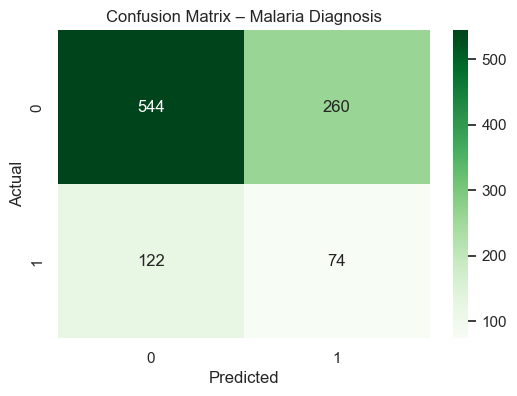

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Malaria Diagnosis")
plt.show()


#  9. Predicted vs Actual Table


In [11]:
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
comparison_df.head(10)


,Actual,Predicted
0,1,0
1,0,0
2,0,1
3,1,0
4,1,0
5,0,0
6,0,0
7,0,1
8,1,0
9,1,1


In [12]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_prob >= 0.35).astype(int)

In [14]:
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))

Precision: 0.19672131147540983
Recall: 0.9183673469387755
F1 Score: 0.324032403240324


After adjusting the prediction threshold from 0.5 to 0.35, the model's recall increased dramatically from 37.8% to 91.8%, indicating that it is now capable of identifying nearly all malaria-positive cases. Although precision decreased to 19.7% due to an increase in false positives, this tradeoff is acceptable in medical diagnosis scenarios where detecting true cases is more critical than minimizing false alarms. This threshold adjustment significantly improves the clinical usefulness of the model.